In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
class GAN():
    def __init__(self, train_data,
                 noise_dim=50, 
                 data_shape=1, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=70, 
                 model_load_Path=None, 
                 start_epoch=0):

        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.train_data = train_data # train data
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch

        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()


        if model_load_Path != None:
            self.discriminator.set_weights(tf.keras.models.load_model(os.path.join(model_load_Path, "age_gan_d.h5")).get_weights())
            self.generator.set_weights(tf.keras.models.load_model(os.path.join(model_load_Path, "age_gan_g.h5"), custom_objects={'wrapperGenerator': wrapperGenerator}).get_weights()) 
        
        self.discriminator.compile(loss='mse',
            optimizer=self.d_optimizer,
            metrics=['accuracy'])
        
        # The generator takes noise as input and generated the events 
        z = Input(shape=(self.noise_dim,))

        # e == age
        e = self.generator(z)
        print(e.shape)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(e)
        
        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        # takes noise, return output
        self.combined = Model(z, [valid])
        self.combined.compile(loss='mse', optimizer=self.g_optimizer)
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.noise_dim,))
        hidden = Dense(64)(inputs) #
        hidden = LeakyReLU(alpha=0.2)(hidden)
#         hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
#         hidden = BatchNormalization()(hidden)
        #hidden = Dense(64)(hidden)
        #hidden = LeakyReLU(alpha=0.2)(hidden)
#         hidden = BatchNormalization()(hidden)
        #hidden = Dense(64)(hidden)
        #hidden = LeakyReLU(alpha=0.2)(hidden)
#         hidden = BatchNormalization()(hidden)
        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)

        generator = Model(inputs=inputs, outputs=output)
        generator.summary()

        return generator


    def build_discriminator(self):
        "build the discriminator model"
        events = Input(shape=(self.data_shape,))
#         norm1 = Input(shape=(1,))
#         norm2 = Input(shape=(1,))
#         h = tf.keras.layers.Concatenate()([events, norm1, norm2])
        h = Dense(64, input_shape=(self.data_shape,))(events) # 128
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        #h = Dense(128)(h)
        #h = LeakyReLU(alpha=0.2)(h)
        #h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        model = Model(events, h)
        model.summary()
        return model

        
    def train(self, epochs, sample_interval=50):
        fake = np.zeros((self.batch_size, 1)) 
        valid = np.ones((self.batch_size, 1))

        for epoch in range(self.start_epoch, epochs):
            # randomly selected indices for the samples for the batch
            indices = np.random.randint(0, self.train_data.shape[0], self.batch_size)

            evnts = self.train_data[indices]

            # 
            noise = tf.random.normal((self.batch_size, self.noise_dim), 0, 1)

            gen_data = self.generator.predict(noise)
            
            # Train the discriminator
            # TODO: intertwine real and fake to have it train on both at once
            d_loss_real = self.discriminator.train_on_batch(evnts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.combined.train_on_batch(noise, [valid])

            if epoch % sample_interval == 0 or epoch == (epochs - 1):
                #self.generator.save("/work/data_science/kishan/Theory/2022.03.20_withNorm_generator_4Params_v2.h5")
                #self.discriminator.save("/work/data_science/kishan/Theory/2022.03.20_withNorm_discriminator_4Params_v2.h5")
                
                num = 2520
                gen_data = self.generate(num)
                
                # plot generated and real
                sns.histplot(gen_data, bins=90, label='GAN')
                sns.histplot(self.train_data, bins=90, color='orange', label='Truth')
                plt.legend()
                plt.show()

    def generate(self, n=None):
        if n == None:
            n = self.train_data.shape[0]

        print("Generating: ", n, " events...")
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        events = self.generator(input_noise)

        return events.numpy()

In [3]:
ages_np = np.load("../data/eICU_age.npy")
print('length: ', len(ages_np))
print(ages_np[0:5])
ages_np_ary = np.asarray(ages_np.flatten().tolist()).flatten()
print('length: ', len(ages_np_ary))
print(ages_np_ary[0:5])

df_ages = pd.DataFrame(ages_np_ary, columns=['age'])
print(df_ages.shape)
df_ages.head()

mean_age = ages_np_ary.mean()
std_age = ages_np_ary.std()
min_age = ages_np_ary.min()
max_age = ages_np_ary.max()

print("mean age: ", mean_age)
print("std age: ", std_age)

scaled_ages = [(x - min_age)/(max_age - min_age) for x in ages_np_ary]

scaled_ages = np.array(scaled_ages)

print(scaled_ages[0:5])

# create data set without 90 or greater since that was a category flattened
print("==" * 30)
print("FILTERED:")
filter_arr = ages_np_ary < 88
ages_np_filtered = ages_np_ary[filter_arr]
print('length: ', len(ages_np_filtered))
print(ages_np_filtered[0:5])

mean_age_filtered = ages_np_filtered.mean()
std_age_filtered = ages_np_filtered.std()
min_age_filtered = ages_np_filtered.min()
max_age_filtered = ages_np_filtered.max()

print("mean age: ", mean_age_filtered)
print("std age: ", std_age_filtered)

scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in ages_np_filtered]
scaled_ages_filtered = np.array(scaled_ages_filtered)

print(scaled_ages_filtered[0:5])



length:  2520
[(87,) (87,) (76,) (34,) (61,)]
length:  2520
[87 87 76 34 61]
(2520, 1)
mean age:  63.28452380952381
std age:  17.721668608381833
[0.96       0.96       0.81333333 0.25333333 0.61333333]
FILTERED:
length:  2364
[87 87 76 34 61]
mean age:  61.59644670050761
std age:  16.992321971601875
[1.         1.         0.84722222 0.26388889 0.63888889]


<function matplotlib.pyplot.show(close=None, block=None)>

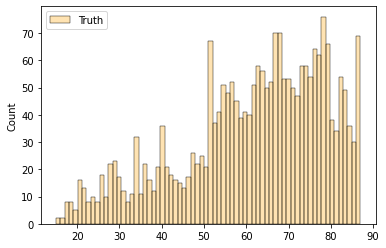

In [4]:
sns.histplot(ages_np_filtered, bins=70, color='orange', label='Truth', alpha=0.3)
plt.legend()
plt.show

In [5]:
gan = GAN(scaled_ages, noise_dim=250, data_shape=1, d_learning_rate=8e-4, g_learning_rate=8e-5, batch_size=560)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

Generating:  2520  events...


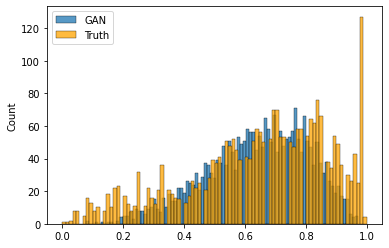

Generating:  2520  events...


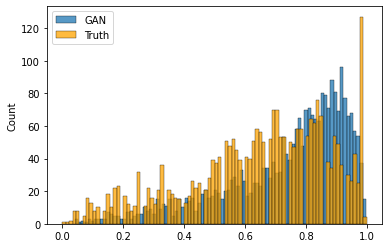

Generating:  2520  events...


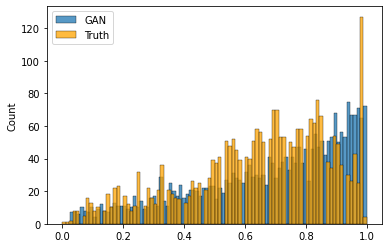

Generating:  2520  events...


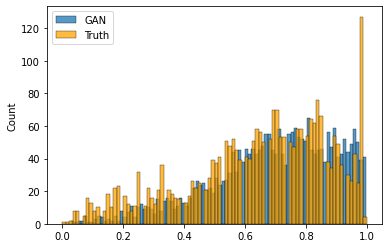

In [6]:
gan.train(15000, sample_interval=5000)

In [7]:
syn_data = gan.generate(2520)
inv_scaled_gen_ages = [(val * (max_age-min_age)) + min_age for val in syn_data]

Generating:  2520  events...


In [8]:
print(np.array(inv_scaled_gen_ages).mean())
print(np.array(inv_scaled_gen_ages).std())

66.98846
15.290238


In [9]:
print(ages_np_ary.mean())
print(ages_np_ary.std())

63.28452380952381
17.721668608381833


<function matplotlib.pyplot.show(close=None, block=None)>

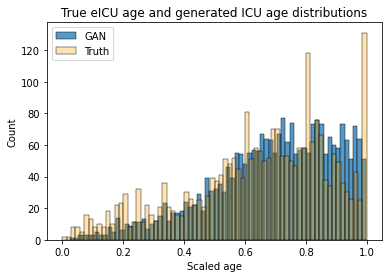

In [10]:
sns.histplot(syn_data, bins=70, label='GAN')
sns.histplot(scaled_ages, bins=70, color='orange', label='Truth', alpha=0.3)
plt.title('True eICU age and generated ICU age distributions')
plt.xlabel('Scaled age')
plt.legend()
plt.show

In [ ]:
gan_filtered = GAN(scaled_ages_filtered, noise_dim=250, data_shape=1, d_learning_rate=8e-4, g_learning_rate=8e-5, batch_size=197)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                128       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0   

Generating:  2520  events...


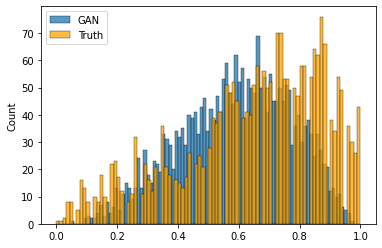

Generating:  2520  events...


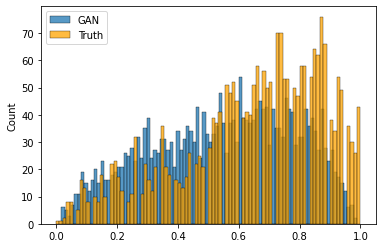

Generating:  2520  events...


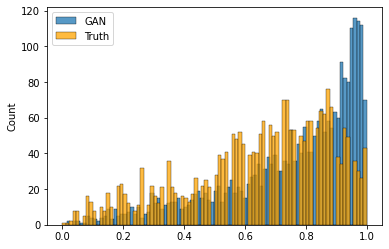

Generating:  2520  events...


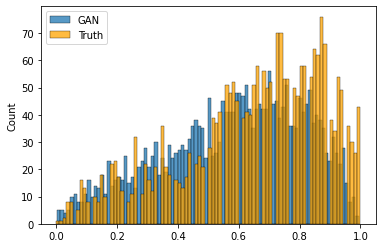

In [ ]:
gan_filtered.train(15000, sample_interval=5000)

Generating:  2520  events...


<function matplotlib.pyplot.show(close=None, block=None)>

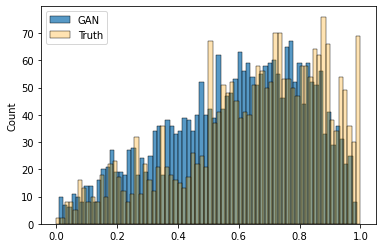

In [ ]:
syn_data_fil = gan_filtered.generate(2520)
sns.histplot(syn_data_fil, bins=70, label='GAN')
sns.histplot(scaled_ages_filtered, bins=70, color='orange', label='Truth', alpha=0.3)
plt.legend()
plt.show